In [1]:
!pip install -q torch torchvision matplotlib
!pip install -q thop torchsummary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from common import *
from resnet18 import *

In [2]:
# Hyperparameters
BATCH_SIZE = 64
EPOCH = 100
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [3]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.4903338  0.48190635 0.44621313] [0.24803042 0.2442158  0.2620374 ]
[0.4903338  0.48190635 0.44621313] [0.24803042 0.2442158  0.2620374 ]


In [4]:
##### data augmentation & normalization #####

# data augmentation
augmentation = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
]

# data normalization    # standardization: (image - train_mean) / train_std
normalization = [transforms.Normalize(mean=train_mean, std=train_std)]

transform_train = transforms.Compose([
    *augmentation,
    transforms.ToTensor(),
    *normalization,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    *normalization,
])

In [5]:
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader, valloader, testloader = get_cifar10_loaders(
    BATCH_SIZE, normalization=normalization, augmentation=augmentation
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4912281  0.48271182 0.44698924], std=[0.24644831 0.24308462 0.2613118 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4912281  0.48271182 0.44698924], std=[0.24644831 0.24308462 0.2613118 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


# Task 2
1. 完成resnet18.py並上傳
2. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [8]:
net = ResNet18().to(DEVICE)
show_model_info(net, input_size=(3, 32, 32))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 37220352.0
Params: 11181642.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
       

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model_path = f'./task2/resnet18_{BATCH_SIZE}.pt'

##### Train model #####
train_loss, train_acc, val_loss, val_acc = train(
    net,
    trainloader,
    valloader,
    epochs=EPOCH,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path=best_model_path,
    early_stop_patience=10,
    existed='overwrite',
    device=DEVICE,
)

Epoch 1/100 (lr=1.0e-03), train_loss: 1.631, val_loss: 1.504, train_acc: 0.405, val_acc: 0.454
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64.pt (44.80703 MB)
Epoch 2/100 (lr=1.0e-03), train_loss: 1.344, val_loss: 1.377, train_acc: 0.514, val_acc: 0.514
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64.pt (44.80703 MB)
Epoch 3/100 (lr=1.0e-03), train_loss: 1.204, val_loss: 1.146, train_acc: 0.573, val_acc: 0.592
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64.pt (44.80703 MB)
Epoch 4/100 (lr=1.0e-03), train_loss: 1.116, val_loss: 1.181, train_acc: 0.606, val_acc: 0.589
Epoch 5/100 (lr=1.0e-03), train_loss: 1.054, val_loss: 1.060, train_acc: 0.628, val_acc: 0.624
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64.pt (44.80703 MB)
Epoch 6/100 (lr=1.0e-03), train_loss: 1.003, val_loss: 1.053, train_acc: 0.650, val_acc: 0.634
Model saved at /home/master_112/nn6124030/eai2024/lab/

Plot saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/loss_accuracy-7.png


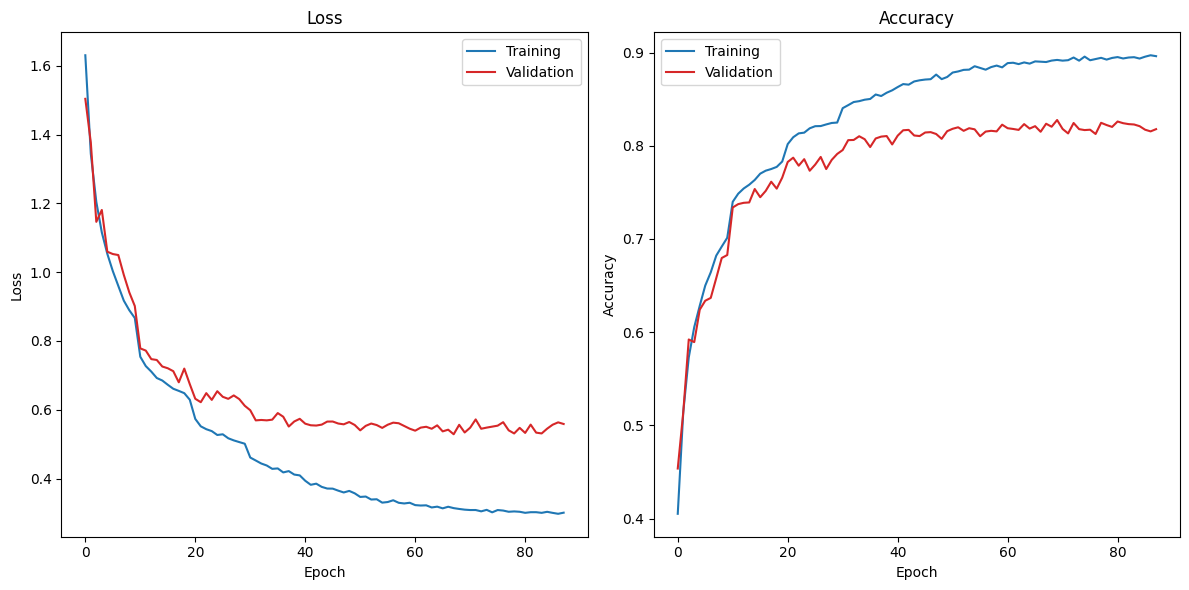

In [10]:
plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename="./task2/loss_accuracy.png")

In [11]:
model = ResNet18().eval().to(DEVICE)
load_model(model, best_model_path)
test_loss, test_acc = evaluate(model, testloader, criterion, device=DEVICE)
print(f'Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}')

Model loaded from ./task2/resnet18_64.pt (44.80703 MB)


Test loss: 0.464, Test accuracy: 0.853


## Ablation Study

In [5]:
def ablation(net, batch_size, normalization, augmentation, optimizer, scheduler, best_model_path):
    EPOCH = 100

    criterion=nn.CrossEntropyLoss()

    trainloader, valloader, testloader = get_cifar10_loaders(
        batch_size, normalization=normalization, augmentation=augmentation
    )

    train_loss, train_acc, val_loss, val_acc = train(
        net.to(DEVICE),
        trainloader,
        valloader,
        epochs=EPOCH,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        save_path=best_model_path,
        early_stop_patience=10,
        existed="overwrite",
        device=DEVICE,
    )

    test_loss, test_acc = evaluate(net, testloader, criterion, device=DEVICE)
    print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")
    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)
transform_test: Compose(
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-03), train_loss: 1.638, val_loss: 1.867, train_acc: 0.402, val_acc: 0.352
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_norm.pt (44.808038 MB)
Epoch 2/100 (lr=1.0e-03), train_loss: 1.348, val_loss: 1.596, train_acc: 0.514, val_acc: 0.458
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_norm.pt (44.808038 MB)
Epoch 3/100 (lr=1.0e-03), train_loss: 1.211, val_loss: 1.369, train_acc: 0.568, val_acc: 0.519
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_norm.pt (44.808038 MB)
Epoch 4/100 (lr=1.0e-03), 

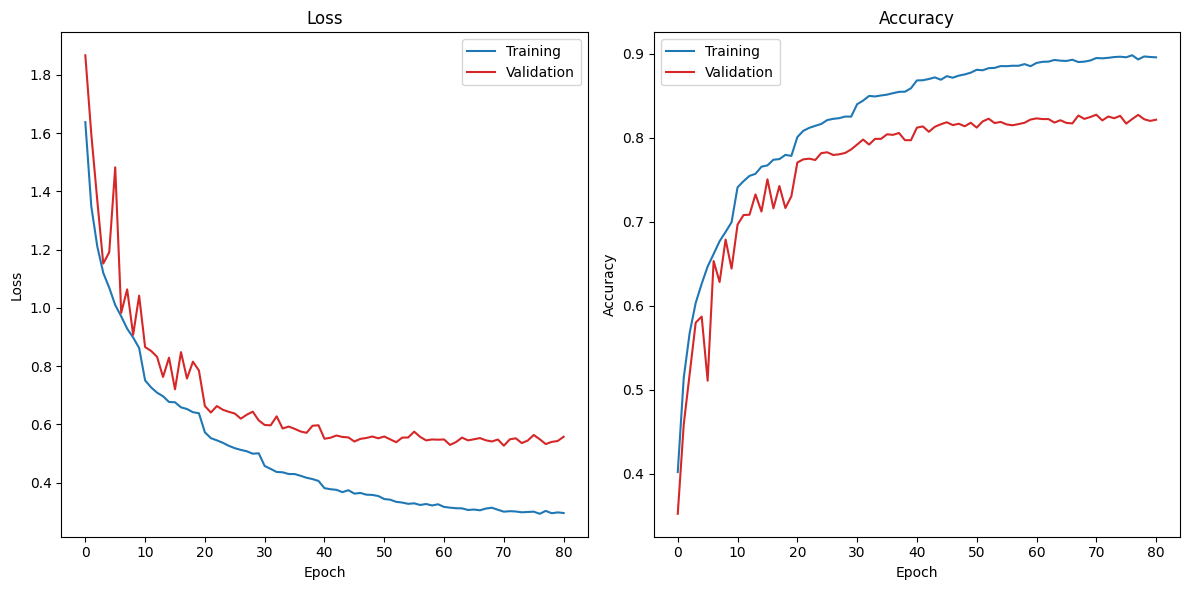

In [7]:
### No input normalization ###

BATCH_SIZE = 64
LR = 1e-3

net=ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
suffix = 'no_norm'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=[],
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-03), train_loss: 1.409, val_loss: 1.201, train_acc: 0.497, val_acc: 0.575
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_aug.pt (44.807912 MB)
Epoch 2/100 (lr=1.0e-03), train_loss: 1.022, val_loss: 1.026, train_acc: 0.641, val_acc: 0.638
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_aug.pt (44.807912 MB)
Epoch 3/100 (lr=1.0e-03), train_loss: 0.869, val_loss: 1.000, train_acc: 0.695, val_acc: 0.657
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_no_aug.pt (44.807912 MB)

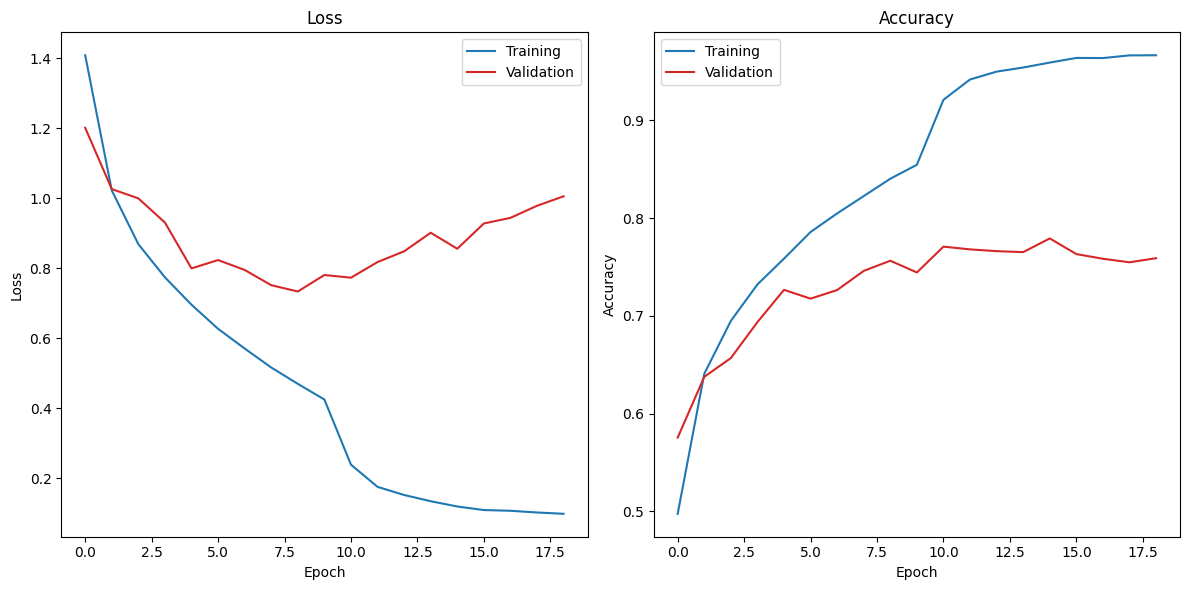

In [9]:
### No data augmentation ###

BATCH_SIZE = 64
LR = 1e-3

net=ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
suffix = 'no_aug'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=[],
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-02), train_loss: 1.963, val_loss: 1.776, train_acc: 0.286, val_acc: 0.329
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_step_lr_2.pt (44.80829 MB)
Epoch 2/100 (lr=1.0e-02), train_loss: 1.632, val_loss: 1.665, train_acc: 0.394, val_acc: 0.377
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_step_lr_2.pt (44.80829 MB)
Epoch 3/100 (lr=1.0e-02), train_

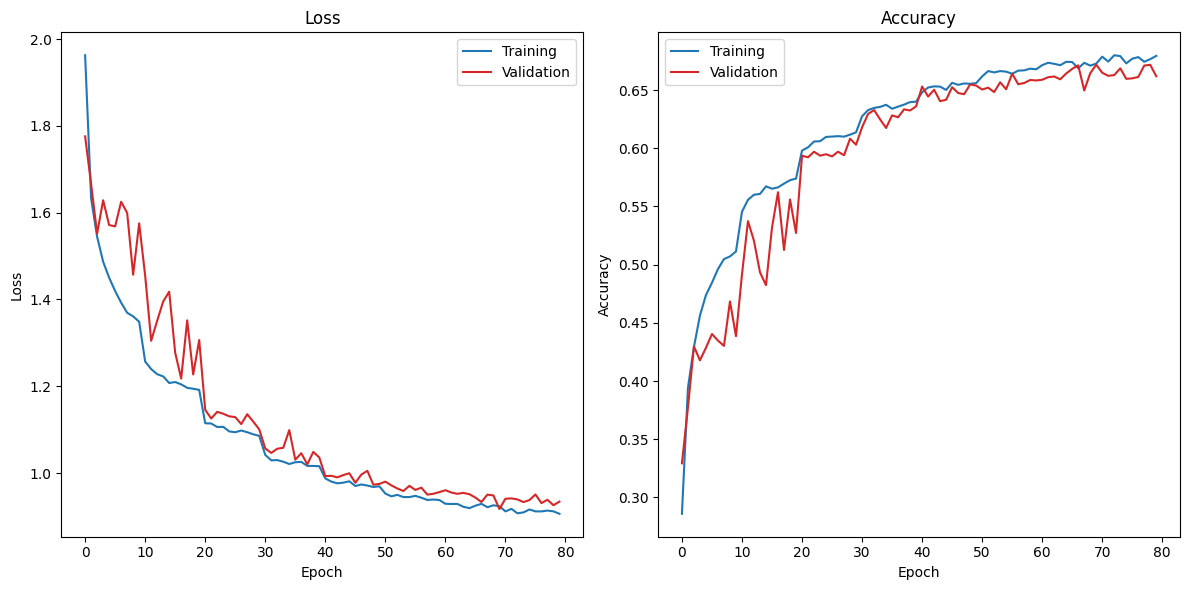

In [10]:
### Different base learning rate 1e-2 ###

BATCH_SIZE = 64
LR = 1e-2

net=ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
suffix = 'step_lr_2'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-04), train_loss: 1.684, val_loss: 1.542, train_acc: 0.386, val_acc: 0.438
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_step_lr_4.pt (44.80829 MB)
Epoch 2/100 (lr=1.0e-04), train_loss: 1.407, val_loss: 1.384, train_acc: 0.490, val_acc: 0.505
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_step_lr_4.pt (44.80829 MB)
Epoch 3/100 (lr=1.0e-04), train_

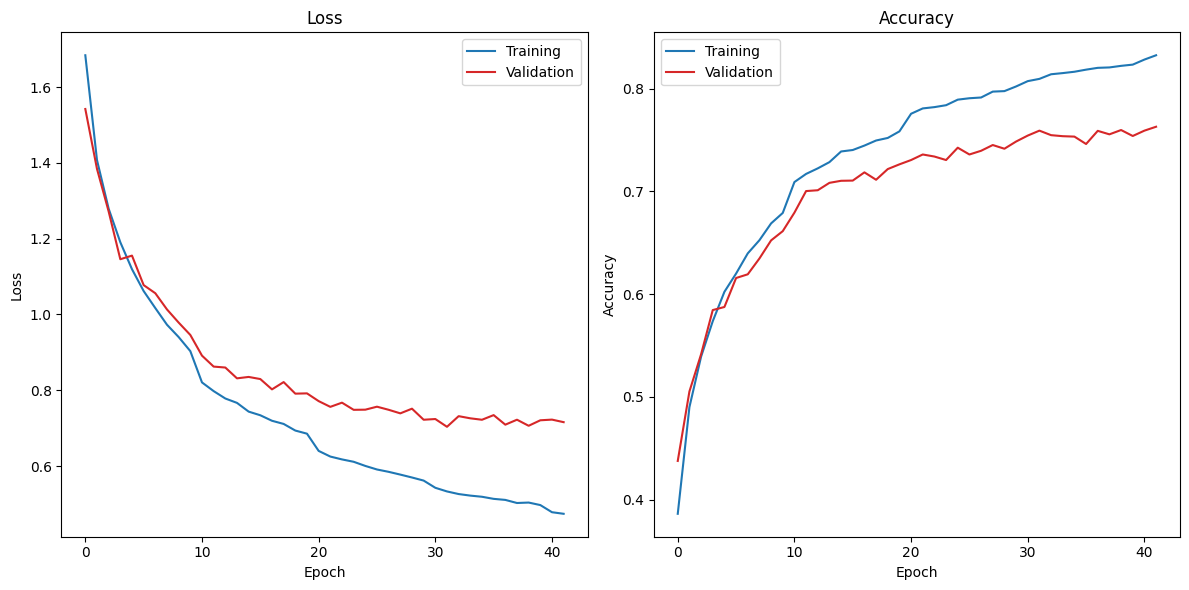

In [11]:
### Different base learning rate 1e-4 ###

BATCH_SIZE = 64
LR = 1e-4

net = ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
suffix = 'step_lr_4'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-02), train_loss: 1.910, val_loss: 1.927, train_acc: 0.303, val_acc: 0.305
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_2.pt (44.80848 MB)
Epoch 2/100 (lr=1.0e-02), train_loss: 1.635, val_loss: 1.674, train_acc: 0.395, val_acc: 0.396
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_2.pt (44.80848 MB)
Epoch 3/100 (lr=1.0e-02), trai

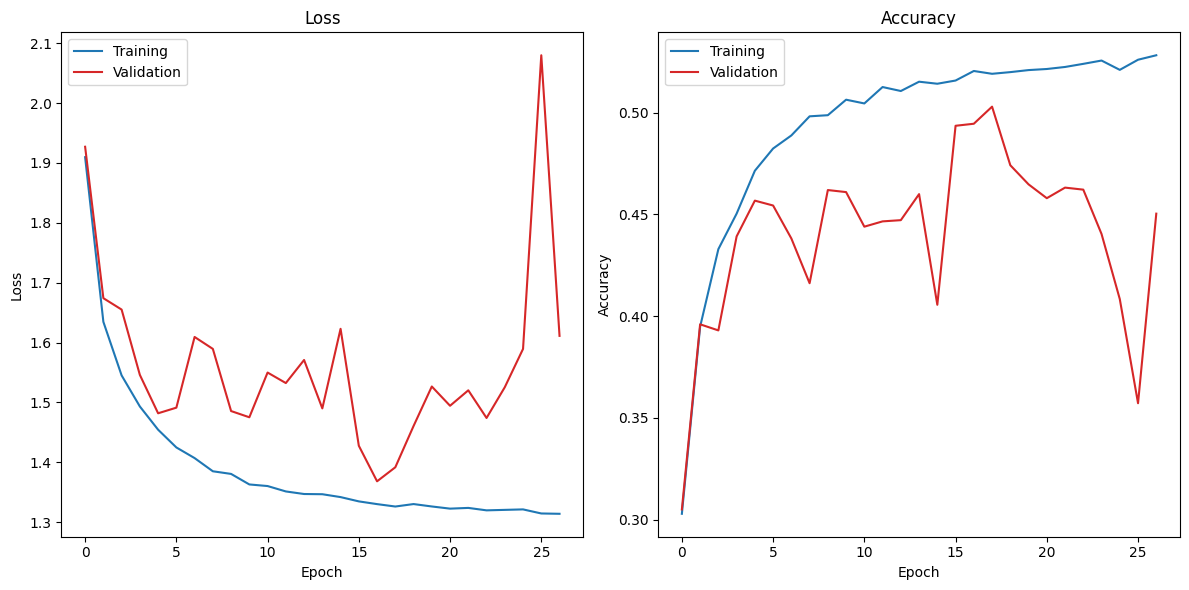

In [12]:
### Constant learning rate 1e-2 ###

BATCH_SIZE = 64
LR = 1e-2

net = ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = None
suffix = 'const_lr_2'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-03), train_loss: 1.644, val_loss: 1.480, train_acc: 0.400, val_acc: 0.459
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_3.pt (44.80848 MB)
Epoch 2/100 (lr=1.0e-03), train_loss: 1.332, val_loss: 1.327, train_acc: 0.522, val_acc: 0.533
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_3.pt (44.80848 MB)
Epoch 3/100 (lr=1.0e-03), trai

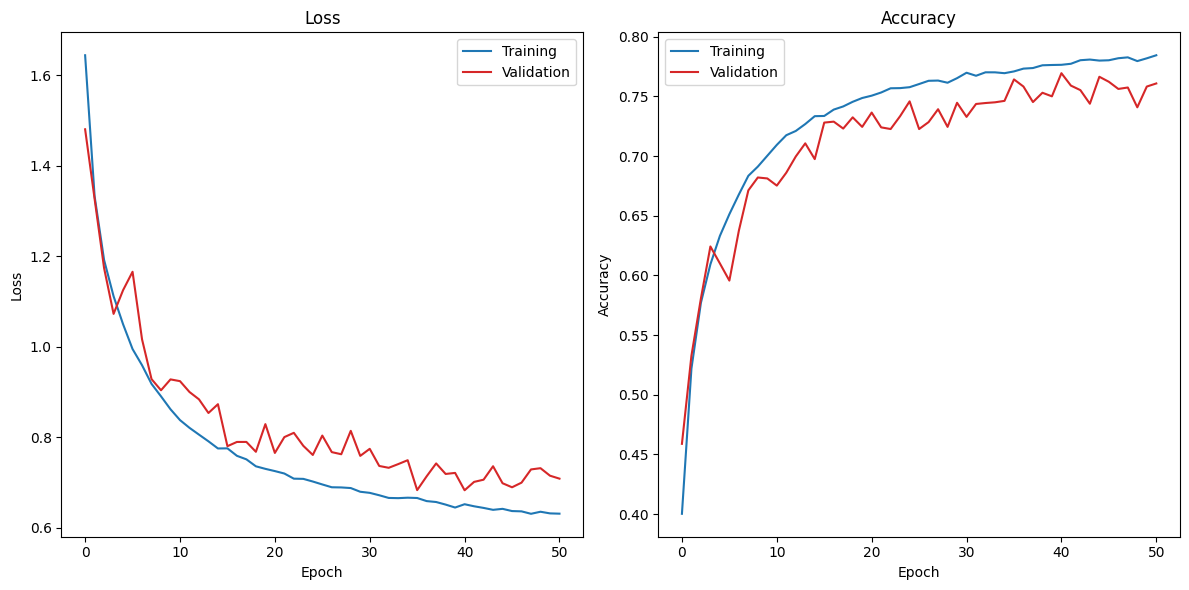

In [13]:
### Constant learning rate 1e-3 ###

BATCH_SIZE = 64
LR = 1e-3

net = ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = None
suffix = 'const_lr_3'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)

transform_train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
transform_test: Compose(
    ToTensor()
    Normalize(mean=[0.4903338  0.48190635 0.44621313], std=[0.24803042 0.2442158  0.2620374 ])
)
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100 (lr=1.0e-04), train_loss: 1.688, val_loss: 1.497, train_acc: 0.385, val_acc: 0.453
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_4.pt (44.80848 MB)
Epoch 2/100 (lr=1.0e-04), train_loss: 1.416, val_loss: 1.396, train_acc: 0.486, val_acc: 0.499
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task2/resnet18_64_const_lr_4.pt (44.80848 MB)
Epoch 3/100 (lr=1.0e-04), trai

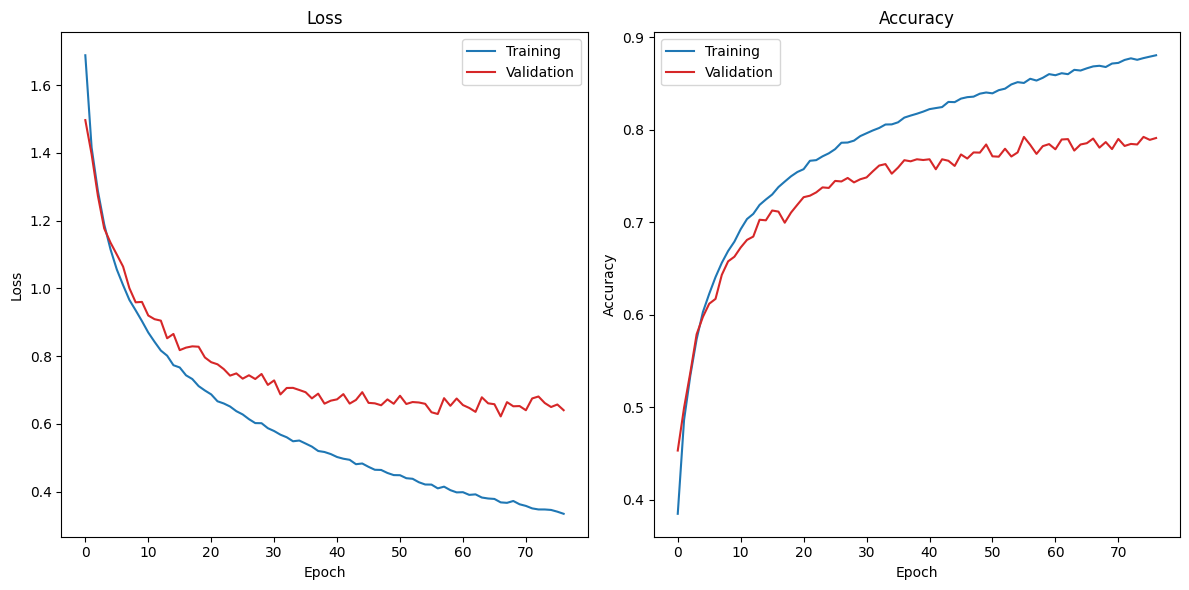

In [14]:
### Constant learning rate 1e-4 ###

BATCH_SIZE = 64
LR = 1e-4

net = ResNet18()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=5e-4)
scheduler = None
suffix = 'const_lr_4'

ablation(
    net=net,
    batch_size=BATCH_SIZE,
    normalization=normalization,
    augmentation=augmentation,
    optimizer=optimizer,
    scheduler=scheduler,
    best_model_path=f"./task2/resnet18_{BATCH_SIZE}_{suffix}.pt",
)